In [1]:
import scPhyloX as spx
import numpy as np
import pandas as pd
import gzip
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines
import pickle
import os

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.size'] = 12

In [3]:
os.chdir('../')

In [4]:
with gzip.open('datasets/simulation/continuous/character_matrix.csv.gz', 'rb') as f:
    charater_matrix = pd.read_csv(f, index_col=0)
charater_matrix = charater_matrix.to_numpy()
with gzip.open('datasets/simulation/continuous/simulation_data.csv.gz', 'rb') as f:
    ground_truth = pd.read_csv(f, index_col=0)
ground_truth = ground_truth.to_numpy()
ground_truth = ground_truth[np.arange(0, ground_truth.shape[0], 1000)]
time = ground_truth[:, 0]
cell_number = ground_truth[:, 1:]

In [5]:
mutnum = spx.data_factory.get_mutnum(charater_matrix)
branch_len = spx.data_factory.get_branchlen(charater_matrix)

100%|██████████| 125250/125250 [00:04<00:00, 25587.14it/s]


In [6]:
idata_bl = spx.est_mr.mutation_rate_mcmc(branch_len, draw=500, tune=500)

Population sampling (4 chains)
DEMetropolis: [mu, delta]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 393 seconds.
/home/wangkun/miniconda3/lib/python3.9/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [14]:
ge = spx.est_mr.GenerationEst(mutnum, 2)
gen_num = ge.estimate(cell_number[-1].sum())

In [15]:
res_de = spx.est_tissue.para_inference_DE(gen_num, T=35, c0=100)

iter99, loss:[435641.9314932], est=[ 0.25089371  0.83941763  2.1572483   1.34032155  2.68410009 17.9645804 ]]]

Text(0, 0.5, 'loss')

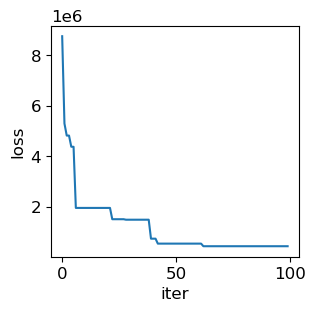

In [24]:
fig, ax = plt.subplots(figsize=(3.2,3))
ax.plot(np.array(res_de[1]).flatten())
ax.set_xlabel('iter')
ax.set_ylabel('loss')

In [30]:
axh, bxh, rh, dh, kh, t0h = res_de[0][-1]
dh = 10**(-dh)
mcmc_prior = (axh, bxh, rh, dh, kh, t0h)

In [31]:
idata = spx.est_tissue.mcmc_inference(gen_num, mcmc_prior, T=35, c0=100, sigma=100)

Population sampling (8 chains)
DEMetropolis: [ax, bx, r, k, t0, d]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 2097 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Text(0.5, 0, 'step')

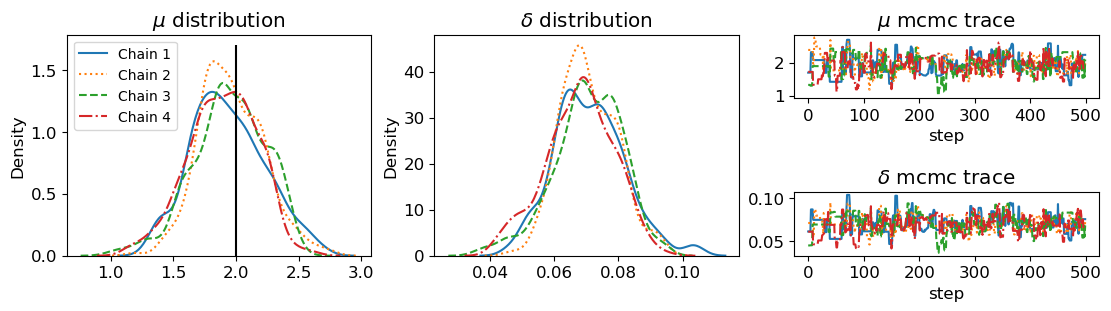

In [38]:
fig = plt.figure(layout='constrained',figsize=(11,3))
gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[:,0])
ls = 'solid,dotted,dashed,dashdot'.split(',')
for i, l in enumerate(ls):   
    sns.kdeplot(idata_bl.posterior['mu'].to_numpy()[i], linestyle=l, ax=ax1, label=f'Chain {i+1}')
ax1.vlines(2, 0, 1.7, color='black')
ax1.legend(fontsize=10,loc=2)
ax1.set_title(r'$\mu$ distribution')

ax2 = fig.add_subplot(gs[:,1])
for i, l in enumerate(ls):  
    sns.kdeplot(idata_bl.posterior['delta'].to_numpy()[i], linestyle=l, ax=ax2, label=f'Chain {i+1}')
ax2.set_title(r'$\delta$ distribution')
ax3 = fig.add_subplot(gs[0,2])
for i, l in enumerate(ls):
    ax3.plot(idata_bl.posterior['mu'][i], linestyle=l, label=f'Chain {i+1}')
ax3.set_title('$\mu$ mcmc trace')
ax3.set_xlabel('step')
ax4 = fig.add_subplot(gs[1,2])
for i, l in enumerate(ls):
    ax4.plot(idata_bl.posterior['delta'][i], linestyle=l, label=f'Chain {i+1}')
ax4.set_title(r'$\delta$ mcmc trace')
ax4.set_xlabel('step')

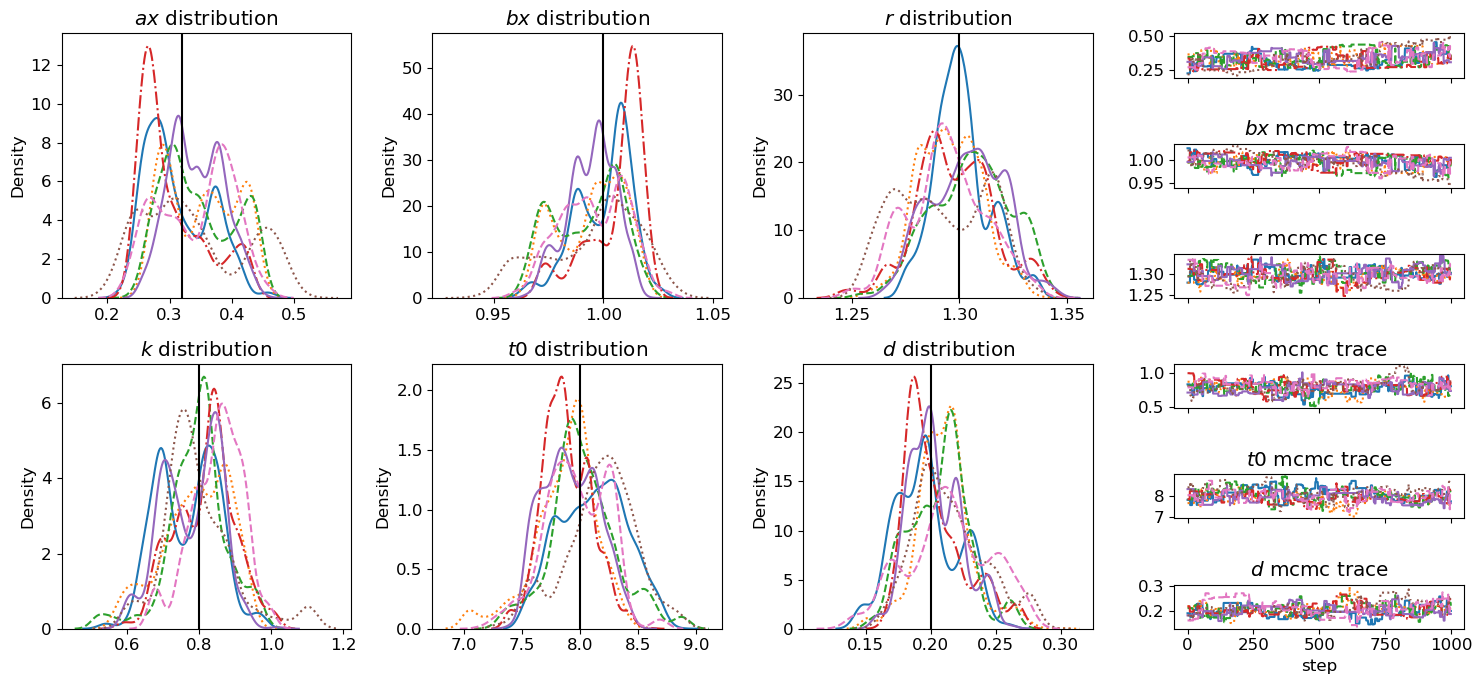

In [35]:
fig = plt.figure(figsize=(15,7))
plt.rcParams['font.size'] = 12
gt = [0.32, 1, 1.3, 0.8, 8, 0.2]
gs = GridSpec(6, 4, figure=fig)
ls = 'solid.dotted.dashed.dashdot.solid.dotted.dashed'.split('.')
for ind, sym in enumerate('ax,bx,r,k,t0,d'.split(',')):
    if ind >= 3:
        ax = fig.add_subplot(gs[3:, ind-3])
    else:
        ax = fig.add_subplot(gs[:3, ind])
    for i, l in enumerate(ls):   
        sns.kdeplot(idata.posterior[sym].to_numpy()[i], linestyle=l, ax=ax, label=f'Chain {i+1}')
    # ax1.legend(fontsize=10,loc=2)
    ylim = ax.get_ylim()
    ax.vlines(gt[ind], *ylim, color='black')
    ax.set_ylim(ylim)
    ax.set_title(fr'${sym}$ distribution')

ax0 = fig.add_subplot(gs[-1, 3])
for i, l in enumerate(ls): 
    ax0.plot(idata.posterior['d'][i], linestyle=l, label=f'Chain {i+1}')
    ax0.set_title(fr'$d$ mcmc trace')
for ind, sym in enumerate('ax,bx,r,k,t0'.split(',')):
    ax = fig.add_subplot(gs[ind, 3], sharex=ax0)
    for i, l in enumerate(ls): 
        ax.plot(idata.posterior[sym][i], linestyle=l, label=f'Chain {i+1}')
        ax.set_title(fr'${sym}$ mcmc trace')
    plt.setp(ax.get_xticklabels(), visible=False)
ax0.set_xlabel('step')
plt.tight_layout()